# Bases de datos espaciales: PostGIS y su integración con Python (Ejemplo de uso)

```{admonition} Guía para el docente
:class: danger
- Incluye ejemplos prácticos en SQL y Python, utilizando tanto `psycopg2` como `SQLAlchemy`.
- El objetivo es facilitar la enseñanza de conceptos espaciales mediante actividades guiadas.
```

```{admonition} Recursos
:class: note

- Capa vectorial (Shapefile de muestras de cobertura): [📥 Muestras_Ejemplo](https://igacoffice365-my.sharepoint.com/:f:/r/personal/juans_hernandez_igac_gov_co/Documents/Recursos_BDE_PostGIS_Diplomado/Muestras_Ejemplo?csf=1&web=1&e=x8juEL)

- Imagen satelital recortada (formato `.tif`): [📥 Imagen_Ejemplo](https://igacoffice365-my.sharepoint.com/:f:/r/personal/juans_hernandez_igac_gov_co/Documents/Recursos_BDE_PostGIS_Diplomado/Imagen_Ejemplo?csf=1&web=1&e=5ZURPK)

Es importante la descarga de los recursos para el desarrollo de la sesión.
```

### Caso de estudio: Administración de datos para generación de modelo clasificador de Bosque / No Bosque por medio de PostGIS y Python

El caso de estudio **"Bosque - No Bosque"** consiste en la clasificación de áreas geográficas en dos categorías: regiones con cobertura boscosa y regiones sin cobertura boscosa. Este análisis es fundamental para la gestión ambiental, la planificación territorial y el monitoreo del cambio climático. Para lograr esta clasificación, se integran **datos ráster y vectoriales** almacenados en una base de datos PostgreSQL, combinados con técnicas de Machine Learning en Python.

El proceso comienza con la extracción de datos ráster almacenados en PostGIS, los cuales contienen información RGB de una imagen satelital. Luego, se combinan con muestras de entrenamiento vectoriales que indican la cobertura real de la tierra, permitiendo entrenar un modelo de clasificación basado en **Random Forest**. Este modelo aprende a diferenciar áreas boscosas y no boscosas a partir de las firmas espectrales de los píxeles.

La **integración de PostGIS y Python** es clave para procesar datos espaciales de manera eficiente. PostGIS permite realizar consultas geoespaciales avanzadas y gestionar datos ráster y vectoriales en una base de datos optimizada, mientras que Python proporciona herramientas avanzadas para el análisis de datos y el entrenamiento de modelos de aprendizaje automático. La combinación de ambas tecnologías permite automatizar la extracción de datos, la clasificación y la visualización de los resultados en mapas interpretables.

Este enfoque facilita la toma de decisiones basadas en datos espaciales, permitiendo la identificación de patrones de deforestación, el monitoreo de la salud de los bosques y la generación de políticas ambientales más efectivas.

Cargar imagen a base de datos espacial

```sh
raster2pgsql.exe -s 32619 -I -C C:\PostGIS_Python\temp_raster.tif > C:\PostGIS_Python\temp_raster.sql

psql -d postgis_34_sample -f C:\PostGIS_Python\temp_raster.sql
```

Importas las liberías necesarias para el caso de uso

In [1]:
import psycopg2                                                                     # Conectar a la base de datos PostgreSQL con PostGIS
import numpy as np                                                                  # Manipulación de arrays numéricos y operaciones matemáticas
import rasterio                                                                     # Manejo y procesamiento de datos ráster
import pandas as pd                                                                 # Manejo de datos tabulares y consultas SQL
from sklearn.model_selection import train_test_split                                # División de datos en entrenamiento y prueba
from sklearn.ensemble import RandomForestClassifier                                 # Algoritmo de clasificación de bosques aleatorios
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Evaluación del modelo
import matplotlib.pyplot as plt                                                     # Generación de gráficos
import seaborn as sns                                                               # Visualización de datos con gráficos estadísticos
import matplotlib.colors as mcolors                                                 # Manejo de colores en visualizaciones
from skimage.transform import resize                                                # Redimensionamiento de imágenes

c:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Configuración de parámetros para conexión con base de datos local

In [2]:
# Configuración de conexión a la base de datos PostgreSQL con PostGIS
DB_CONFIG = {
    "dbname": "postgis_34_sample",      # Nombre de la base de datos
    "user": "postgres",                 # Usuario de la base de datos
    "password": "postgres",             # Contraseña del usuario
    "host": "localhost",                # Dirección del servidor (localhost si es local)
    "port": "5432"                      # Puerto predeterminado de PostgreSQL
}

def conectar_postgis():
    """
    Establece una conexión a la base de datos PostgreSQL con soporte PostGIS.
    Retorna:
        conn (psycopg2.connection): Objeto de conexión a la base de datos.
    """
    conn = psycopg2.connect(**DB_CONFIG)  # Conectar a la base de datos usando la configuración definida
    return conn

Extraer el ráster almacenado en la base de datos espacial

In [3]:
# Establece la conexión con la base de datos PostgreSQL con PostGIS
conn = conectar_postgis()
# Crea un cursor para ejecutar consultas SQL
cur = conn.cursor()
# Ejecuta una consulta SQL para obtener un ráster desde la base de datos en formato GDAL (GeoTIFF)
cur.execute("SELECT ST_AsGDALRaster(rast, 'GTiff') FROM temp_raster LIMIT 1;")
# Recupera el resultado de la consulta (raster_bin contiene los datos del ráster en formato binario)
raster_bin = cur.fetchone()[0]
# Guarda temporalmente la imagen ráster en un archivo local (GeoTIFF)
with open("temp_raster.tif", "wb") as f:
    f.write(raster_bin)
# Abre la imagen ráster utilizando rasterio
with rasterio.open("temp_raster.tif") as src:
    raster_array = src.read()   # Carga el contenido del ráster como un array NumPy
    transform = src.transform   # Obtiene la transformación del ráster (ubicación y resolución espacial)
# Cierra el cursor y la conexión a la base de datos para liberar recursos
cur.close()
conn.close()

Extraer los datos de muestras (Geometría punto. Bosque - No Bosque)

In [4]:
# Establece la conexión con la base de datos PostgreSQL con PostGIS
conn = conectar_postgis()
# Consulta SQL para extraer coordenadas y etiquetas de clasificación desde la tabla de muestras de entrenamiento
query = """
SELECT ST_X(geom) AS lon, ST_Y(geom) AS lat, class FROM training_sample;
"""
# Ejecuta la consulta y almacena los resultados en un DataFrame de pandas
df = pd.read_sql(query, conn)
# Cierra la conexión con la base de datos para liberar recursos
conn.close()
df

C:\Users\ingju\AppData\Local\Temp\ipykernel_23332\1185105217.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,lon,lat,class
0,333600.852280,710803.977512,Bosque
1,333797.267675,710693.129220,Bosque
2,333865.332416,710844.816356,Bosque
3,334120.089017,710615.340945,Bosque
4,334166.761982,710842.871650,Bosque
...,...,...,...
448,341516.593621,710043.829290,No_Bosque
449,341264.365708,710577.958988,No_Bosque
450,341219.854900,710934.045452,No_Bosque
451,340774.746819,710704.072944,No_Bosque


Extraer los valores de píxel de cada banda del ráster para cada muestra

In [ ]:
# Listas para almacenar los valores de los píxeles extraídos y sus respectivas etiquetas
valores_pixeles = []
etiquetas = []
# Iteramos sobre cada fila del DataFrame que contiene las muestras de entrenamiento
for _, row in df.iterrows():
    lon, lat, label = row['lon'], row['lat'], row['class']                              # Extraemos las coordenadas y la clase de la muestra    
    # Convertimos coordenadas geográficas (lon, lat) a índices de píxel en la imagen ráster
    row_idx, col_idx = ~transform * (lon, lat)                                          # Aplicamos la transformación inversa
    row_idx, col_idx = int(row_idx), int(col_idx)                                       # Convertimos a enteros para obtener la posición en la matriz ráster
    # Verificamos que las coordenadas convertidas estén dentro de los límites del ráster
    if 0 <= row_idx < raster_array.shape[1] and 0 <= col_idx < raster_array.shape[2]:
        # Extraemos los valores de las bandas del píxel correspondiente y los almacenamos en la lista
        valores_pixeles.append([
            raster_array[0, row_idx, col_idx],  # Banda 1 (Ej. Rojo)
            raster_array[1, row_idx, col_idx],  # Banda 2 (Ej. Verde)
            raster_array[2, row_idx, col_idx]   # Banda 3 (Ej. Azul)
        ])
        etiquetas.append(label)                                                         # Almacenamos la etiqueta de la muestra en la lista
# Convertimos las listas a arreglos NumPy para su uso en el modelo de Machine Learning
X, y = np.array(valores_pixeles), np.array(etiquetas)

Dividir el universo de muestras en grupos de entrenamiento y validación

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Entrenamiento del modelo de clasificación

In [7]:
# Inicialización del modelo de clasificación Random Forest
modelo = RandomForestClassifier(
    n_estimators=1000,      # Número de árboles en el bosque
    max_depth=10,           # Profundidad máxima de cada árbol para evitar sobreajuste
    max_features="sqrt",    # Número máximo de características consideradas en cada división (raíz cuadrada del total)
    random_state=42,        # Fijamos una semilla para asegurar reproducibilidad de resultados
    n_jobs=-1               # Utiliza todos los núcleos de la CPU disponibles para acelerar el entrenamiento
)
# Entrenamiento del modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)
# Realización de predicciones sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

Evaluación del rendimiento del modelo

Precisión: 0.5735294117647058
Exactitud del modelo: 0.5735


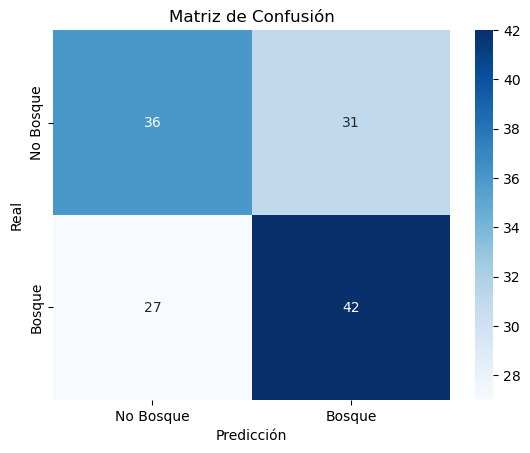

              precision    recall  f1-score   support

   No Bosque       0.57      0.54      0.55        67
      Bosque       0.58      0.61      0.59        69

    accuracy                           0.57       136
   macro avg       0.57      0.57      0.57       136
weighted avg       0.57      0.57      0.57       136



In [8]:
# Cálculo de la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)  # Imprime la precisión global del modelo
# Cálculo de la exactitud del modelo con formato de 4 decimales
exactitud = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {exactitud:.4f}")
# Cálculo de la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualización de la matriz de confusión con Seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Bosque", "Bosque"], 
            yticklabels=["No Bosque", "Bosque"])
# Etiquetas para los ejes
plt.xlabel("Predicción")            # Etiqueta del eje X
plt.ylabel("Real")                  # Etiqueta del eje Y
plt.title("Matriz de Confusión")    # Título del gráfico
plt.show()                          # Mostrar la matriz de confusión
# Generación del informe de clasificación con métricas detalladas
print(classification_report(y_test, y_pred, target_names=["No Bosque", "Bosque"]))

Aplicación del modelo para predecir la clase de cada píxel en la imagen ráster

In [9]:
filas, columnas = raster_array.shape[1], raster_array.shape[2]  # Extraemos el número de filas y columnas del ráster
# Reestructuramos la imagen ráster en una matriz donde cada fila es un píxel y las columnas son las bandas espectrales
raster_reshaped = raster_array.reshape(3, -1).T                 # Convertimos a formato (N, 3), donde N es el número total de píxeles
predicciones = modelo.predict(raster_reshaped)                  # Aplicamos el modelo entrenado para predecir la clase de cada píxel en la imagen ráster
predict_ = predicciones.reshape(filas, columnas)                # Reformateamos las predicciones en la misma estructura de la imagen original (filas, columnas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


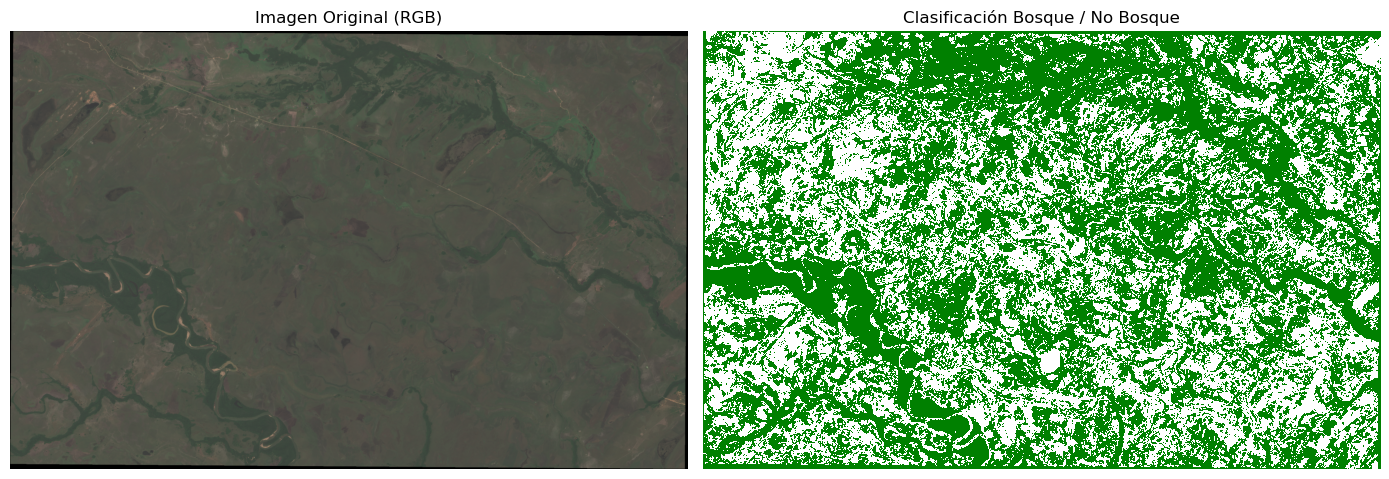

In [10]:
mapa_clases = {"No_Bosque": 0, "Bosque": 1}                         # Diccionario de mapeo de clases: Asigna valores numéricos a las etiquetas de clasificación
predict_numeric = np.vectorize(mapa_clases.get)(predict_)           # Convierte la matriz de predicciones categóricas a valores numéricos usando el diccionario de mapeo
filas, columnas = raster_array.shape[1], raster_array.shape[2]      # Extraemos las dimensiones de la imagen original
# Redimensionamos la imagen predicha para ajustarla a la resolución original del ráster
predict_resized = resize(
    predict_numeric, (filas, columnas), 
    order=0,                                                        # Mantiene valores discretos sin interpolación
    anti_aliasing=False,                                            # Evita suavizar los bordes para mantener las clases bien definidas
    preserve_range=True                                             # Mantiene los valores originales sin normalización
)
cmap = mcolors.ListedColormap(["green", "white"])                   # Definimos un mapa de colores para visualizar la clasificación. "Bosque" será verde, "No Bosque" será blanco
bounds = [0, 0.5, 1]                                                # Definimos los límites de cada clase en el mapa de colores
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))                      # Creamos una figura con 2 subgráficos (1 fila, 2 columnas)
# Construimos una imagen en color RGB a partir de las bandas del ráster original
raster_rgb = np.stack([
    raster_array[0],  # Banda Roja
    raster_array[1],  # Banda Verde
    raster_array[2]   # Banda Azul
], axis=-1)
raster_rgb = raster_rgb.astype(np.float32)                          # Normalizamos los valores del ráster RGB para mejorar la visualización
raster_rgb /= raster_rgb.max()
axs[0].imshow(raster_rgb)                                           # Mostramos la imagen original en la primera columna
axs[0].set_title("Imagen Original (RGB)")
axs[0].axis("off")                                                  # Oculta los ejes para mejorar la visualización
img = axs[1].imshow(predict_resized, cmap=cmap, norm=norm)          # Mostramos la clasificación "Bosque / No Bosque" en la segunda columna
axs[1].set_title("Clasificación Bosque / No Bosque")
axs[1].axis("off")
plt.tight_layout()                                                  # Ajusta el diseño de la figura para evitar solapamientos
plt.show()                                                          # Muestra la figura con las dos imágenes

In [11]:
output_raster_path = "clasificacion_bosque.tif"
transform = rasterio.open("temp_raster.tif").transform  # Extrae la transformación del raster original
# Guardar el resultado en un nuevo raster GeoTIFF
with rasterio.open(
    output_raster_path, "w",
    driver="GTiff",
    height=predict_resized.shape[0], 
    width=predict_resized.shape[1],
    count=1,  # Una sola banda (clasificación)
    dtype=rasterio.uint8,  # Tipo de datos para la clasificación (0 y 1)
    crs="EPSG:32619",  # Asegurar que tenga el mismo CRS que la imagen original
    transform=transform
) as dst:
    dst.write(predict_resized.astype(rasterio.uint8), 1)

In [13]:
import psycopg2     # psycopg2: Librería para conectar Python con bases de datos PostgreSQL. Permite ejecutar consultas SQL, manipular datos y gestionar transacciones.
import subprocess   # subprocess: Módulo para ejecutar comandos del sistema desde Python. Se usa para llamar programas externos como psql, raster2pgsql, etc.
import os

DB_CONFIG = {
    "dbname": "postgis_34_sample",      # Nombre de la base de datos
    "user": "postgres",                 # Usuario de la base de datos
    "password": "postgres",             # Contraseña del usuario
    "host": "localhost",                # Dirección del servidor (localhost si es local)
    "port": "5432"                      # Puerto predeterminado de PostgreSQL
}
conn = psycopg2.connect(**DB_CONFIG) 
cur = conn.cursor()
# Abrir el archivo raster (.tif)
notebook_dir = os.getcwd()                                                              # Ruta donde se ejecuta el notebook
raster_path = os.path.join(notebook_dir, "clasificacion_bosque.tif")    # Ruta del archivo .tif  (Cambiar según sea necesario)
os.environ["PGPASSWORD"] = DB_CONFIG["password"]

# Ruta a la carpeta donde están raster2pgsql y psql
pg_bin_path = r"C:\Program Files\PostgreSQL\16\bin"         # Cambiar según la instalación de PostgreSQL
sql_output_path = r"C:\Shp_Example\classify_raster.sql"     # Ruta de salida para el archivo SQL (Cambiar según sea necesario)
# Construir el comando con la ruta completa de raster2pgsql y psql
cmd = fr'"{pg_bin_path}\raster2pgsql.exe" -s 32619 -I -C "{raster_path}" >  {sql_output_path}'
# Ejecutar el comando en la terminal
process = subprocess.run(cmd, shell=True, capture_output=True, text=True)

cmd = fr'"{pg_bin_path}\psql.exe" -d {DB_CONFIG["dbname"]} -U {DB_CONFIG["user"]} -h {DB_CONFIG["host"]} -p {DB_CONFIG["port"]} -f "{sql_output_path}"'
# Ejecutar el comando
process = subprocess.run(cmd, shell=True, capture_output=True, text=True)
# Limpiar la variable de entorno después de ejecutar el comando
del os.environ["PGPASSWORD"]
print(process.stdout)

BEGIN
CREATE TABLE
INSERT 0 1
CREATE INDEX
ANALYZE
 addrasterconstraints 
----------------------
 t
(1 fila)

COMMIT



```{image} Imagenes/Load_Classify.png
:width: 500px
:align: center
:alt: unidad
```
<p style="text-align: center; font-size: 12px;"> 
<strong>Fig. 1. Conexión a base de datos espacial desde QGIS para visualización de resultados </strong>
</p>

```{admonition} Actividad
:class: important
- **Este recuadro está destinado a preguntas y actividades para los estudiantes.**

🧠 **Reflexión: ¿Cómo se integraron los componentes?**

- En el caso de estudio, ¿qué papel cumple cada una de estas herramientas?
  - `PostGIS`
  - `psycopg2` / `SQLAlchemy`
  - `GeoPandas` y `Rasterio`
  - `scikit-learn` u otra librería de ML

> Escribe una breve explicación de cómo cada componente contribuyó al flujo general del análisis.

🔁 **Del SIG al modelo: automatiza tu flujo**

> Diseña un flujo básico (puede ser en pseudocódigo o diagrama) que represente los pasos que seguiste en el caso de estudio, desde la carga del shapefile y ráster hasta la generación del modelo.

- ¿Qué tareas podrías automatizar para futuros análisis?
- ¿Qué parte requiere más validación manual?

📉 **Reflexión sobre el desempeño del modelo**

Tu modelo de clasificación alcanzó una **exactitud de aproximadamente 57 %**, lo que indica que comete errores en más del 40 % de los casos.

Analiza la matriz de confusión y responde:

1. ¿A qué clase está confundiendo más el modelo?
2. ¿Qué clase predice mejor?
3. ¿Qué te dicen las métricas `precision`, `recall` y `f1-score` en ambas clases?

Ahora piensa:

- ¿Qué aspectos podrías mejorar del conjunto de entrenamiento?
- ¿Qué pasaría si añades más muestras o balanceas la cantidad de clases?
- ¿Podrías incluir nuevas variables (features) como NDVI, textura, elevación?
- ¿Cambiarías el modelo o los parámetros de entrenamiento?

> 💬 Escribe una breve propuesta de mejora para tu modelo de clasificación y explica por qué podría ayudar a mejorar el rendimiento.


### Referencias y Recursos

#### 🗃️ Bases de datos y SQL
- [¿Qué es una base de datos? — Oracle](https://www.oracle.com/co/database/what-is-database/)
- [Introducción a PostgreSQL](https://www.postgresql.org/docs/current/intro-whatis.html)
- [Documentación oficial de PostgreSQL](https://www.postgresql.org/docs/current/)
- [Lenguaje SQL en PostgreSQL — Comandos y estructura](https://www.postgresql.org/docs/current/sql.html)

---

#### 🌐 PostGIS y funciones espaciales
- [Sitio oficial de PostGIS](https://postgis.net/)
- [Funciones espaciales en PostGIS — Manual 1.5 (imagen usada)](https://postgis.net/docs/manual-1.5/ch08.html)
- [Carga de datos vectoriales en PostGIS](https://postgis.net/docs/manual-3.5/using_postgis_dbmanagement.html#loading-data)
- [Manejo de datos ráster en PostGIS](https://postgis.net/docs/using_raster_dataman)

---

#### 🐍 Python + PostgreSQL/PostGIS
- [GeoPandas — Documentación oficial](https://geopandas.org/en/stable/)
- [Shapely — Documentación oficial](https://shapely.readthedocs.io/en/stable/)
- [Psycopg2 — PostgreSQL adapter para Python](https://www.psycopg.org/docs/)
- [SQLAlchemy — Documentación oficial](https://docs.sqlalchemy.org/en/20/)
- [GeoAlchemy2 — Extensión espacial para SQLAlchemy](https://geoalchemy-2.readthedocs.io/en/latest/)

---

#### 💻 Herramientas y entornos de desarrollo
- [JupyterBook — Documentación oficial](https://jupyterbook.org/en/stable/)
- [Jupyter Notebook — Sitio oficial](https://jupyter.org/)
- [Extensión oficial de Python para VS Code](https://marketplace.visualstudio.com/items?itemName=ms-python.python)
